# Set up directory

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

## to make sure the file can be rerun
try:
    shutil.rmtree('./rs_streetviews')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


try:
    shutil.rmtree('./houses')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

"""Unzip the data file. Note this only needs to be done once! Hence it is commented out."""

# !unzip -q /content/drive/MyDrive/'Colab Notebooks'/uni_project_data.zip
# !ls


# copying images to a different folder to move the images
shutil.copytree('uni_project_data/street_view_juny12', 'houses')

# reading in image names
flist = os.listdir('./houses')


# csv with labels
prop = pd.read_csv("uni_project_data/properties_juny12.csv")
prop['id'] = "gsv_" + prop["property_id"] + ".jpg"

im = pd.DataFrame(flist, columns = ['dir'])
im['id'] = im['dir'].apply(os.path.basename)

# merging the property id, image name and labels into one dataframe
props = prop.merge(im, on = 'id', how='inner')
props.head()

# checking for any duplicates
len(props[props.duplicated() == True])

# separating unknwon properties
unknown_props = props[props['propertyType']== 'Unknown']
known_props = props[props['propertyType'] != 'Unknown']

# splitting train, validation and test sets
from sklearn.model_selection import train_test_split
trainval_set, test_set = train_test_split(known_props,
                                          train_size = 0.85,
                                          shuffle = True,
                                          stratify = known_props['propertyType'],
                                          random_state = 42)

trainval_set = trainval_set.reset_index(drop = True)
test_set = test_set.reset_index(drop = True)


class_names = list(known_props['propertyType'].unique())

trainval_set = trainval_set.sort_values('propertyType')
test_set = test_set.sort_values('propertyType')


# creating subfolders to read in data using tf.keras.utils.image_dataset_from_directory
os.makedirs('rs_streetviews/trainval')
for c in class_names:
    dest = 'rs_streetviews/trainval/' + c
    os.makedirs(dest)
    for i in list(trainval_set[trainval_set['propertyType'] == c]['id']): # Image Id
        get_image = os.path.join('houses', i) # Path to Images
        shutil.move(get_image, dest)

os.makedirs('rs_streetviews/test')
for c in class_names:
    dest = 'rs_streetviews/test/' + c
    os.makedirs(dest)
    for i in list(test_set[test_set['propertyType'] == c]['id']): # Image Id
        get_image = os.path.join('houses', i) # Path to Images
        move_image_to_cat = shutil.move(get_image, dest)


# Visualisations

Found 13852 files belonging to 4 classes.
Using 11359 files for training.


2023-07-07 17:30:15.722815: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


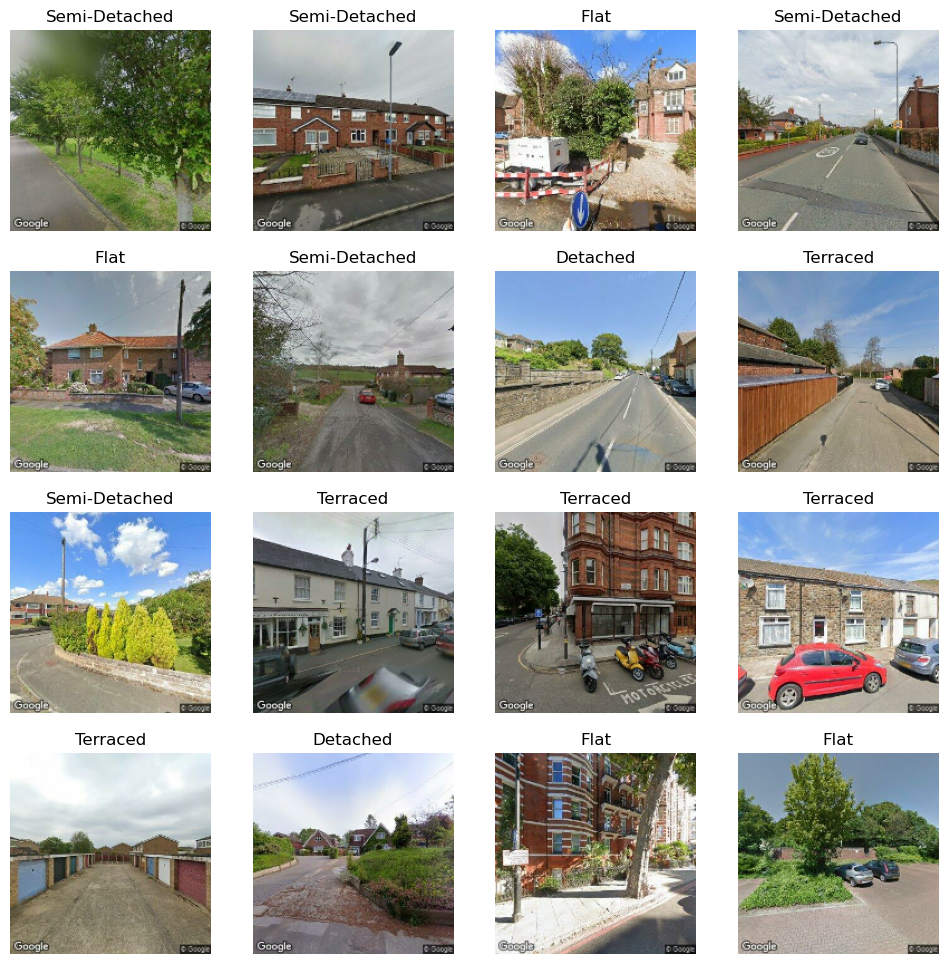

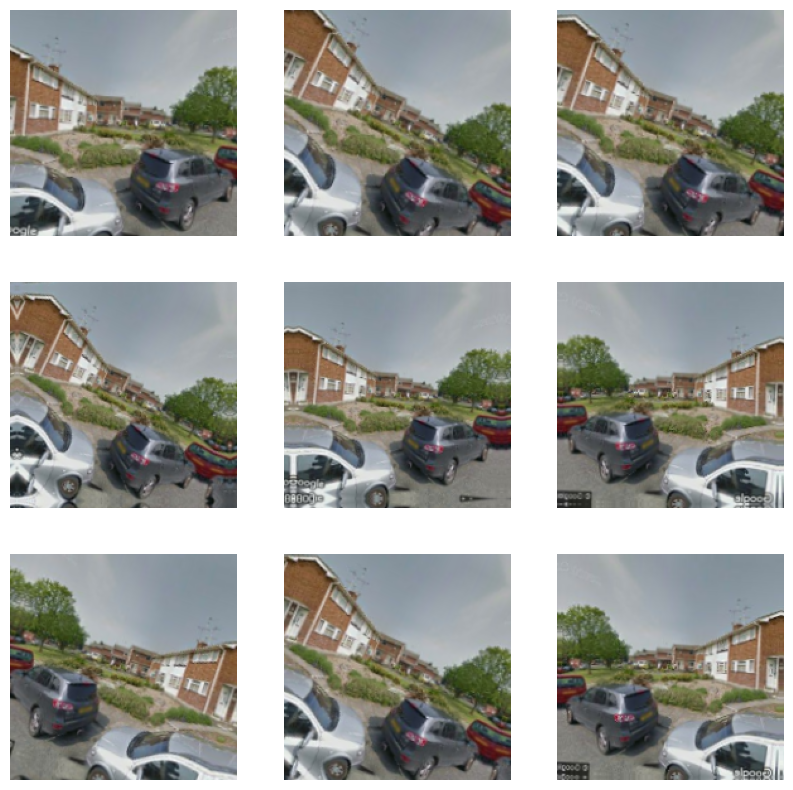

In [2]:
# train_ds is only used for visualisation in the EDA and preprocessing section of the report
# easier to navigate using label encoders


batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  './rs_streetviews/trainval',
  validation_split=0.18,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

# to save: uncomment code
# plt.savefig('classplot.png', bbox_inches='tight')
# plt.close()

from tensorflow.keras.models import Sequential

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1) # zooming in 10%,
  ]
)

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[5]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
plt.show()

# to save: uncomment code
# plt.savefig('augmentation.png', bbox_inches='tight')
# plt.close()

# MobileNet

Found 13852 files belonging to 4 classes.
Using 11359 files for training.
Found 13852 files belonging to 4 classes.
Using 2493 files for validation.
Found 2445 files belonging to 4 classes.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100  

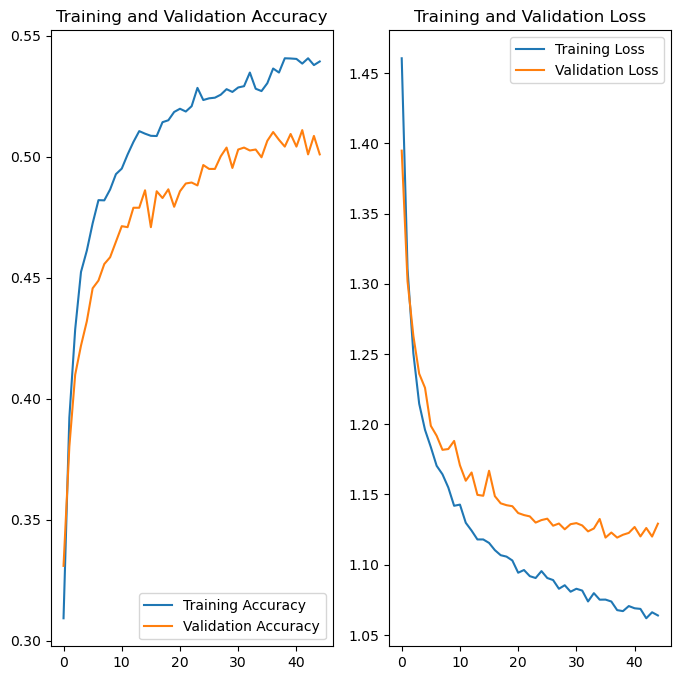

In [3]:
# only presenting code for mobilenet
# the rest of the models' scripts are on the github link in the appendix of report

# reading in data
batch_size = 32
img_height = 224
img_width = 224

# roughly 70% , 15%, 15% train validation test split

train_dataset = tf.keras.utils.image_dataset_from_directory(
  './rs_streetviews/trainval',
  validation_split=0.18,
  subset = "training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  './rs_streetviews/trainval',
  validation_split=0.18,
  subset = "validation",
  label_mode = 'categorical',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    './rs_streetviews/test',
    image_size = (img_height, img_width),
    label_mode = 'categorical',
    batch_size = batch_size)

# saving class names
val_class_names = validation_dataset.class_names
test_class_names = test_dataset.class_names

class_names = train_dataset.class_names
num_classes = len(class_names)

# preprocessing for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# calling in weights of mobilenet parameters on imagenet
base_model = tf.keras.applications.MobileNet(input_shape = (img_height, img_width, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# freezing the base model to obtain better initialization when fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# preprocessing - data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1) # zooming in 10%,
  ]
)

rescale = tf.keras.layers.Rescaling(1./255)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# building the model by chaining
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)

# Add a final softmax layer with 4 nodes for classification output
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)

# compile model
base_learning_rate = 0.0001
model.compile(optimizer = optimizers.Adam(learning_rate=base_learning_rate), 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['acc'])

model.summary()

# early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc', 
    patience = 8, 
    min_delta = 0.001, 
    mode='max'
)

# model fitting
initial_epochs = 50
mobnet_history = model.fit(train_dataset, 
                                validation_data = validation_dataset, 
                                epochs = initial_epochs,
                                verbose = 2,
                                callbacks = early_stopping)

# saving the whole model
model.save('modelmobnet_update2.h5')
saved_model = tf.keras.models.load_model('modelmobnet_update2.h5')
saved_model.summary()

# train and validation metrics
train_loss, train_acc = saved_model.evaluate(train_dataset, verbose=2)
print('Restored model, train accuracy: {:5.2f}%'.format(100 * train_acc))
print('Restored model, train loss: {}'.format(train_loss))

val_loss, val_acc = saved_model.evaluate(validation_dataset, verbose=2)
print('Restored model, val accuracy: {:5.2f}%'.format(100 * val_acc))
print('Restored model, val loss: {}'.format(val_loss))

# training progress
acc = mobnet_history.history['acc']
val_acc = mobnet_history.history['val_acc']

loss = mobnet_history.history['loss']
val_loss = mobnet_history.history['val_loss']

init_epoch = len(acc)

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fine-tuning

Number of layers in the base model:  86
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)       

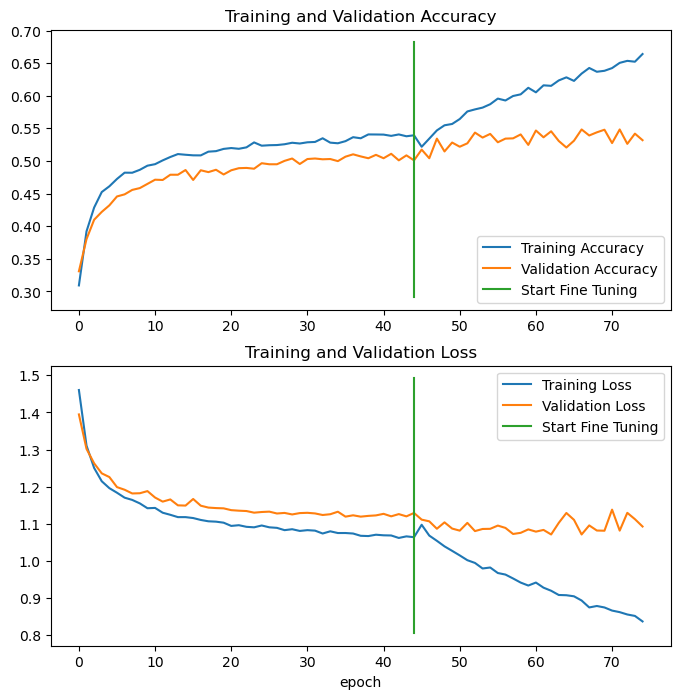

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100  

In [4]:
print("Number of layers in the base model: ", len(base_model.layers))

# unfreezing the last 35 layers
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers)-34]:
    layer.trainable = False

# training with lower learning rate
model.compile(optimizer = optimizers.Adam(learning_rate=base_learning_rate/10), 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['acc'])

model.summary()

# also adopting early stopping
fine_tune_epochs = 75
total_epochs = init_epoch + fine_tune_epochs
mobnetfine_history = model.fit(train_dataset, 
                                validation_data = validation_dataset, 
                                epochs = total_epochs,
                                initial_epoch = mobnet_history.epoch[-1],
                                callbacks = early_stopping)

# fine-tuned training progress
acc += mobnetfine_history.history['acc']
val_acc += mobnetfine_history.history['val_acc']

loss += mobnetfine_history.history['loss']
val_loss += mobnetfine_history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([init_epoch-1,init_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([init_epoch-1,init_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# saving fine-tuned model
model.save('modelftmobnet_update2.h5')
saved_model = tf.keras.models.load_model('modelftmobnet_update2.h5')
saved_model.summary()


# train and validation metrics
train_loss, train_acc = saved_model.evaluate(train_dataset, verbose=2)
print('Restored model, train accuracy: {:5.2f}%'.format(100 * train_acc))
print('Restored model, train loss: {}'.format(train_loss))

val_loss, val_acc = saved_model.evaluate(validation_dataset, verbose=2)
print('Restored model, val accuracy: {:5.2f}%'.format(100 * val_acc))
print('Restored model, val loss: {}'.format(val_loss))

# Evaluation on test set

78/78 [==============================] - 6s 71ms/step
[[322  28 107 132]
 [ 30 277  37 137]
 [162  29 232 268]
 [ 87  49 101 495]]


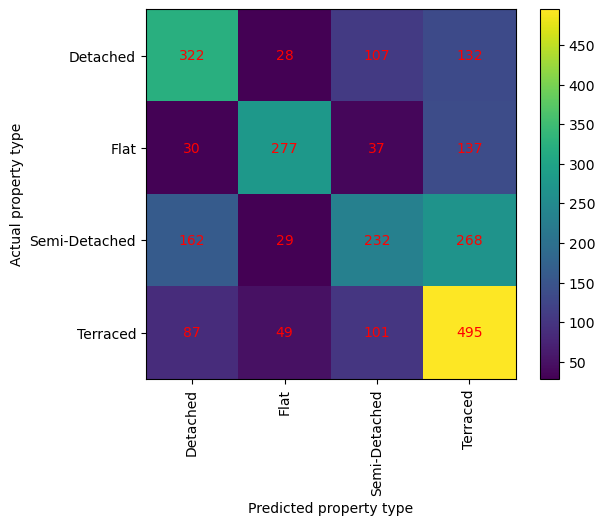

77/77 - 6s - loss: 1.1199 - acc: 0.5374 - 6s/epoch - 75ms/step
Restored model, test accuracy: 53.74%
Restored model, test loss: 1.1198781728744507
77/77 [==============================] - 5s 67ms/step
[[297  29 113 140]
 [ 39 269  27 130]
 [159  34 262 233]
 [ 80  50  97 486]]


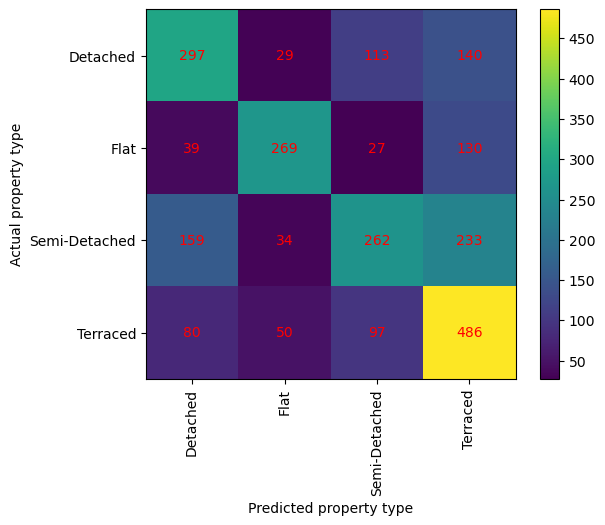

[0.682, 0.491, 0.571, 713]

In [5]:
# to make predictions, and decode one hot encoding to create confusion matrix
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = saved_model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  actual = tf.argmax(actual, axis=1)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

# returns and plots confusion matrix heatmap
def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  confmat = cm.numpy()
  print(confmat)
  fig, ax = plt.subplots()
  im = ax.imshow(confmat)
  fig.colorbar(im, ticks=list(np.arange(stop = np.max(confmat), step = 50)))
  # plt.set(font_scale=1.4)
  for i in range(len(labels)):
    for j in range(len(labels)):
        plt.annotate(str(confmat[i][j]), xy=(j, i),
                     ha='center', va='center', color='red')
 
  ax.set_xlabel('Predicted property type')
  ax.set_ylabel('Actual property type')
  ax.set_xticks(np.arange(confmat.shape[0]), labels = labels)
  ax.set_yticks(np.arange(confmat.shape[1]), labels = labels)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.show()
  return confmat

# validation confusion matrix
actual, predicted = get_actual_predicted_labels(validation_dataset)
plot_confusion_matrix(actual, predicted, val_class_names)


# evaluation on test dataset
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)



test_loss, test_acc = saved_model.evaluate(test_dataset, verbose=2)
print('Restored model, test accuracy: {:5.2f}%'.format(100 * test_acc))
print('Restored model, test loss: {}'.format(test_loss))

test_actual, test_predicted = get_actual_predicted_labels(test_dataset)
confmat = plot_confusion_matrix(test_actual, test_predicted, test_class_names)

# class specific metrics to obtain precision, recall and f1-score
def class_metrics(confmat, label, label_names):
    ind = label_names.index(label)
    tp = confmat[ind][ind]
    total  = np.sum(confmat)
    col_total = np.sum(confmat, axis=0)[ind]
    row_total = np.sum(confmat, axis=1)[ind]
    fp = row_total - tp
    fn = col_total - tp
    tn = total - (tp + fn + fp)
    prec = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(prec*recall/(prec + recall))
    support = row_total
    metrics = [prec, recall, f1, support]
    return [round(met, 3) for met in metrics]


class_metrics(confmat, 'Terraced', test_class_names) 

# Model Comparison

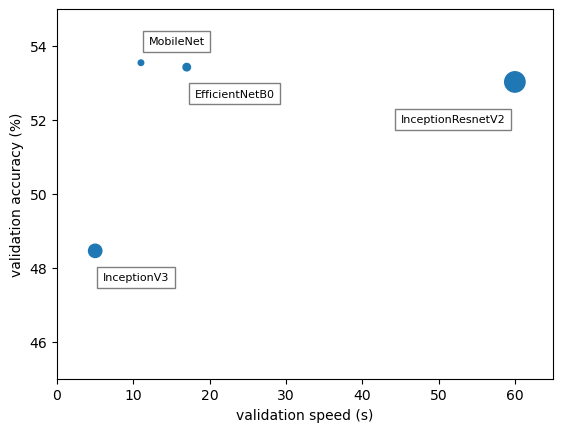

In [6]:
# model comparison: data read in manually
model_list = ['EfficientNetB0', 'InceptionV3', 'InceptionResnetV2', 'MobileNet']
img_dim = [224, 150, 299, 224]
size = [29, 92, 215, 16]
validation_accuracy = [53.43, 48.46, 53.03, 53.55]
speed = [17,5,60,11]

models = {'model': model_list, 
          'image_size': img_dim, 
          'val_acc': validation_accuracy, 
          'MB': size, 
          'speed': speed}

models = pd.DataFrame(models)

# bubble plots for model comparison
plt.scatter('speed', 'val_acc', s='MB', data = models)
plt.ylim((45,55))
plt.xlim((0,65))
plt.xlabel('validation speed (s)')
plt.ylabel('validation accuracy (%)')

# labeling bubble plots
plt.text(x=models.speed[0]+1,y=models.val_acc[0]-0.8,s=models.model[0], 
      fontdict=dict(color='black',size=8),
      bbox=dict(facecolor='white',alpha=0.5))

plt.text(x=models.speed[1]+1,y=models.val_acc[1]-0.8,s=models.model[1], 
      fontdict=dict(color='black',size=8),
      bbox=dict(facecolor='white',alpha=0.5))

plt.text(x=models.speed[2]-15,y=models.val_acc[2]-1.1,s=models.model[2], 
      fontdict=dict(color='black',size=8),
      bbox=dict(facecolor='white',alpha=0.5))

plt.text(x=models.speed[3]+1,y=models.val_acc[3]+0.5,s=models.model[3], 
      fontdict=dict(color='black',size=8),
      bbox=dict(facecolor='white',alpha=0.5))
plt.show()
